In [68]:
import numpy as np
import pandas as pd
import xlrd

import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq
from scipy.signal import butter, lfilter, freqz
from scipy import signal

from sklearn.model_selection import train_test_split
import glob

fs = 114000
# fs = 2380000
# fs = 1140000
cutoff = 56000 #in Hz

def get_fft_set(file_names):
    fft_set = []
    for files in file_names:
        data = pd.read_csv(files)
        fft_data = fft_from_data_frame(data)
        fft_set = fft_data + fft_set
    return fft_set

def fft_from_data_frame(data_frame):
    signal_set = []
    nan_indexes = np.where(np.any(np.isnan(data_frame.values), axis=1))
    data_frame_values = np.delete(data_frame.values, nan_indexes, axis=0)
    for row in data_frame_values:
        fft_data = fft(row, n=row.size)/row.size
        freq = fftfreq(row.size, d=1/fs)
        cut_high_signal = abs(fft_data).copy()
        cut_high_signal[(freq > 50000)] = 0
        cut_high_signal[(freq < 30000)] = 0
        signal_without_0 = list(filter(lambda a: a != 0, cut_high_signal))
#         signal_set.append(np.abs(signal_without_0))
        signal_set.append(np.abs(cut_high_signal))
    return signal_set

order = 5
NOISE_SIZE = 350
DATA_HEADERS_SIZE = 9


def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass_filter(data):
    b, a = butter_lowpass(cutoff, fs, order=order)
    #y = lfilter(b, a, data)
    y = signal.filtfilt(b, a, data)
    
    b, a = butter_highpass(30000,fs,order)
    y_ = signal.filtfilt(b, a, y)
    return y_


def plot_graphs(data):
    fig = plt.figure(figsize=(30, 20))
    for index, data in enumerate(data):
        counter = 0
        if index < 30:
            ax = fig.add_subplot(7,7, index + 1)
            ax.plot(data)
#             peaks, _ = find_peaks(data, height=0)
#             ax.plot(peaks, data[peaks])
            
def find_echo(data, window_size = 100):
    rolling_max = data.rolling(window=window_size, axis=1).max()
    length = data.shape[1]
            
            
#Step 1 and 2
def get_time_domain_without_offset(data_frame):
    required_data_frame = data_frame.iloc[:, 370:]
    #print(data_frame)
    #print(required_data)
    return required_data_frame.sub(required_data_frame.mean(axis=1), axis=0)

In [75]:
human_data = glob.glob('../../data/1mhz_data/human/human_A/110/*.csv')
# '../../data/114KHz_Data/Human/Human_A/80/1.csv'
# human_data = pd.read_csv('../../data/114KHz_Data/Human/Human_A/80/1.csv', skiprows=[0], header= None)
# human_data = pd.read_csv('../../data/2MHz_data/Human/Side_Standing_Black_Jeans/80/1.csv', skiprows=[0], header= None)
# human_data = pd.read_csv('../../data/Offset/114KHz.csv', skiprows=[0], header= None)

human_data = pd.read_csv('../../data/114KHz_Data/Human/Human_B/90/1.csv', skiprows=[0], header= None)
human_data_without_offset = get_time_domain_without_offset(human_data)

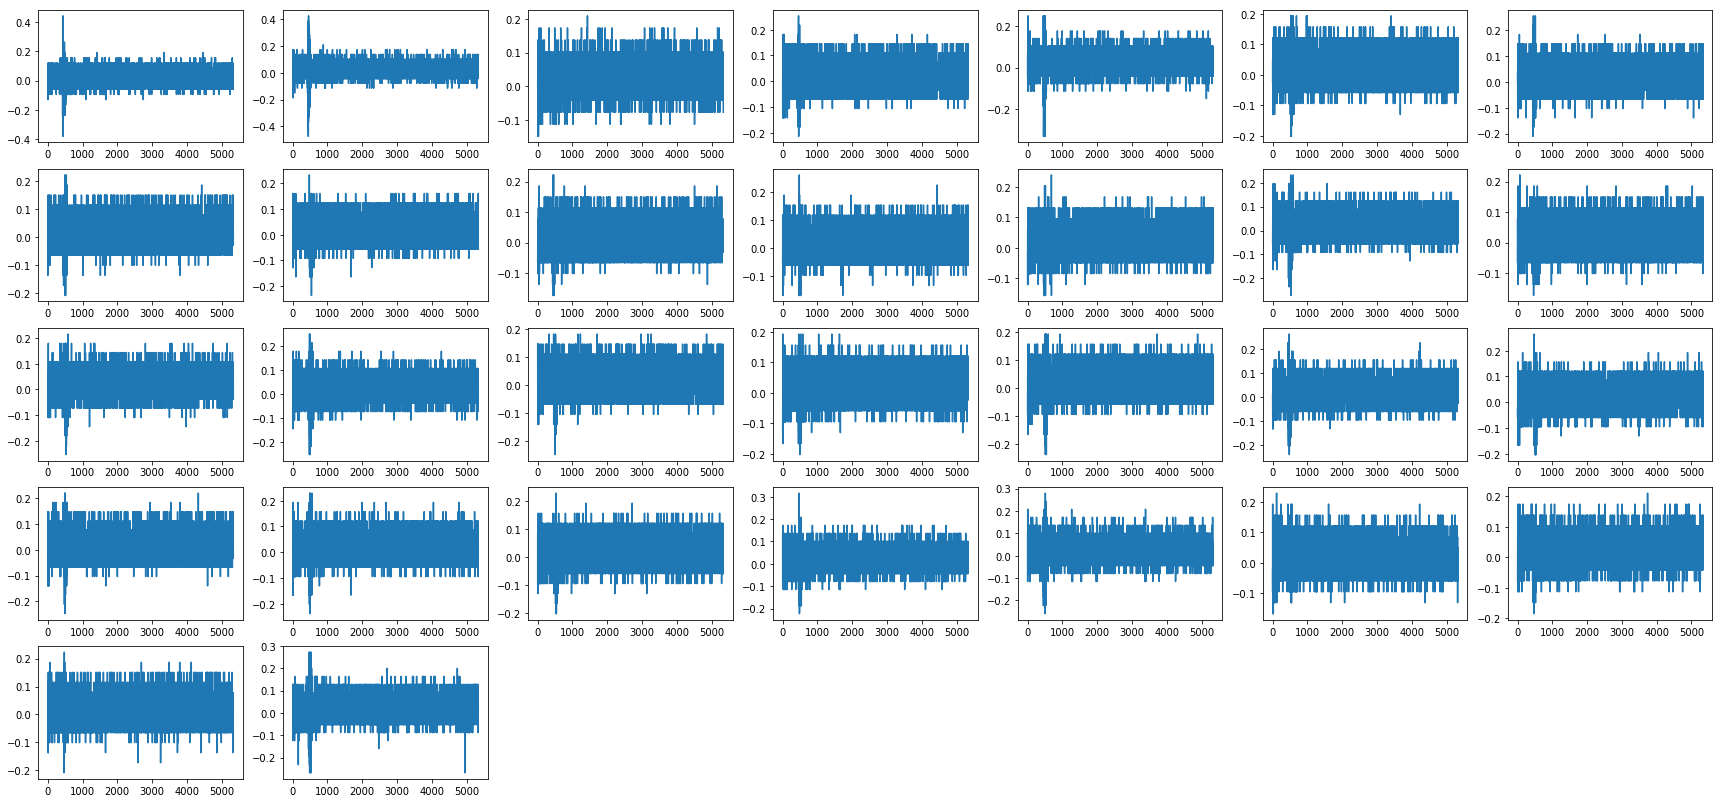

In [69]:
plot_graphs(human_data_without_offset.values)

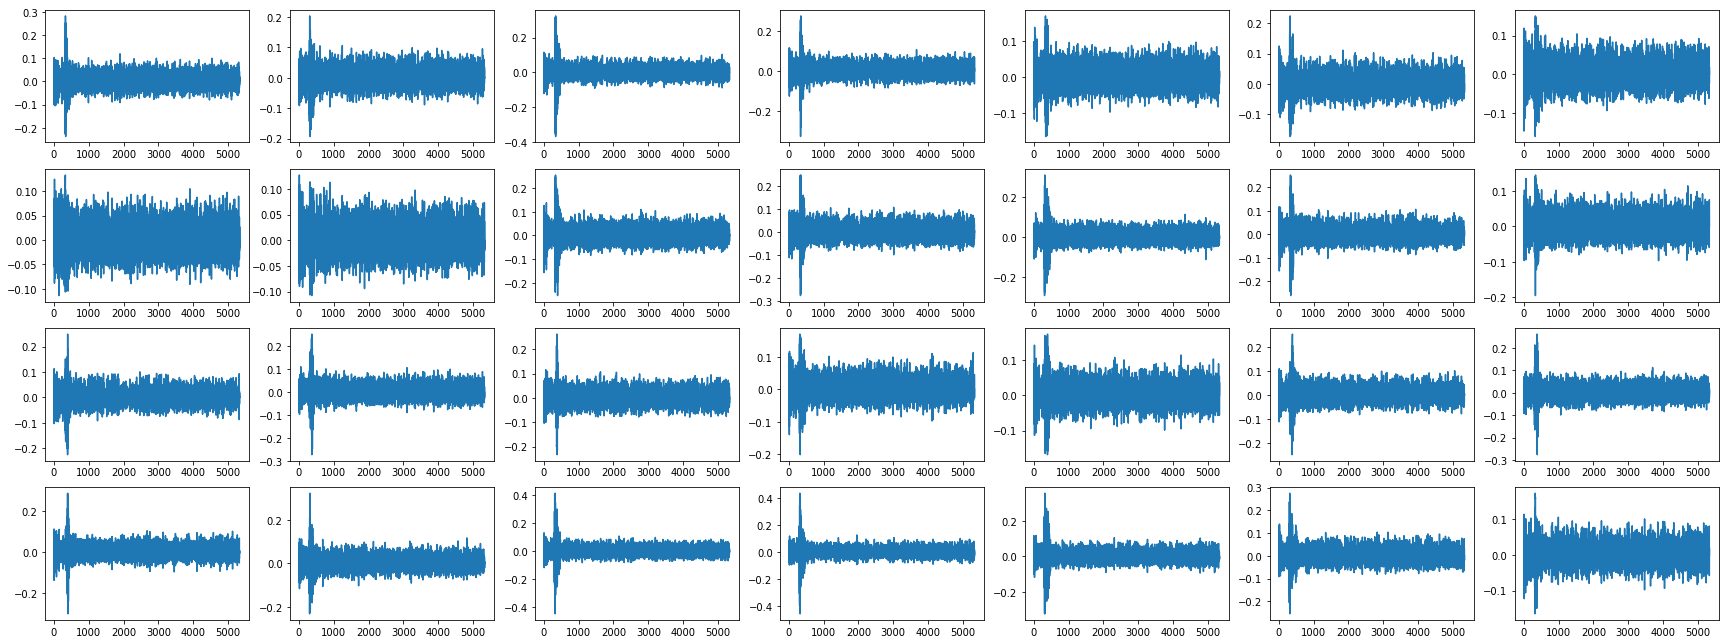

In [76]:
new_data= []
for data in human_data_without_offset.values:
    new_data.append(butter_lowpass_filter(data))
new_data = np.array(new_data)
plot_graphs(new_data)

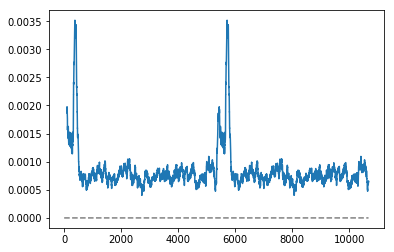

In [78]:
dfObj = pd.DataFrame(new_data) 
result = pd.concat([dfObj, dfObj], axis=1, sort=False)
a = result.rolling(window=100, axis=1).var()
value = a.values[7]
peaks, _ = signal.find_peaks(value, height=0.011)        
plt.plot(value)
plt.plot(peaks, value[peaks], "x")
plt.plot(np.zeros_like(value), "--", color="gray")
plt.show()


In [124]:
a = 2
b = [1,2,3,3,34,3,43,4,34,3,43,4,3]
b[a:]

[3, 3, 34, 3, 43, 4, 34, 3, 43, 4, 3]

In [8]:
window_max_result = []
window_size = 100
for single_value in a.values:
    single_value_window = []
    for val in range (1,round(single_value.shape[0]/window_size) + 1):
        single_value_window.append(single_value[val*window_size])
    window_max_result.append(single_value_window)

In [9]:
ECHO_SIZE = 1024

length_of_window = len(window_max_result[0])
for single_window in window_max_result: 
    index = 0 
    first_max_result = np.array(single_window[index:]).argmax()
    
    if first_max_result > (ECHO_SIZE/2)/window_size):
        print(first_max_result)
        
    
    while (first_max_result < (ECHO_SIZE/2)/window_size):
        index+=1
        first_max_result = np.array(single_window[index:]).argmax()
        
#     TODO: back_logic_missing

SyntaxError: invalid syntax (<ipython-input-9-0b9c95c75299>, line 8)

In [200]:
def peak_value(data):
    max_point_distance = 0
    peakData = 0
    max_point_distance = np.array(data).argmax()
    peakData = np.array(data).max()
    print(peakData, max_point_distance)
    return max_point_distance
    
def get_echos(filtered_values):
#     chopped_data = data[NOISE_SIZE:]
    max_point_distance = peak_value(filtered_values)
    if max_point_distance:
        cutting_distance = max_point_distance - 512
        if cutting_distance > 0:
            echo_range = chopped_data[cutting_distance:]
            echo_range = echo_range[:1024]
        else:
            echo_range = []
    return echo_range


In [201]:
a1 = a.iloc[:, 99:]
# get_echos(a1.values[13])
np.array(a1.values[0]).argmax()


0

import sys
from scipy import stats
a = stats.zscore(new_data[0])
plot_graphs([a])
plot_graphs([new_data[0]])

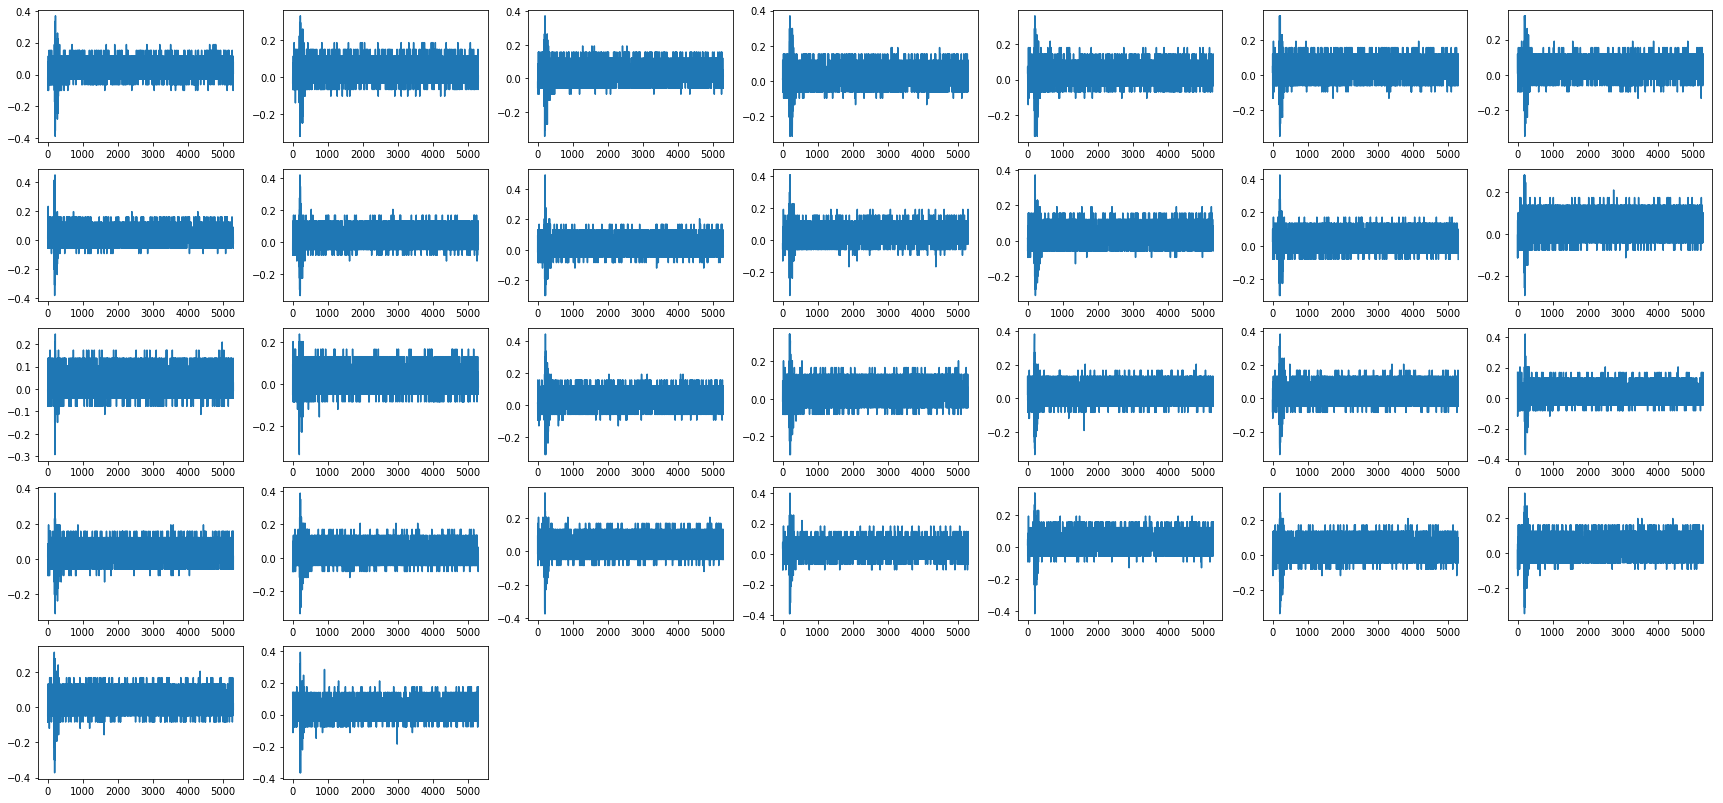

In [650]:
plot_graphs(human_data_without_offset.values)

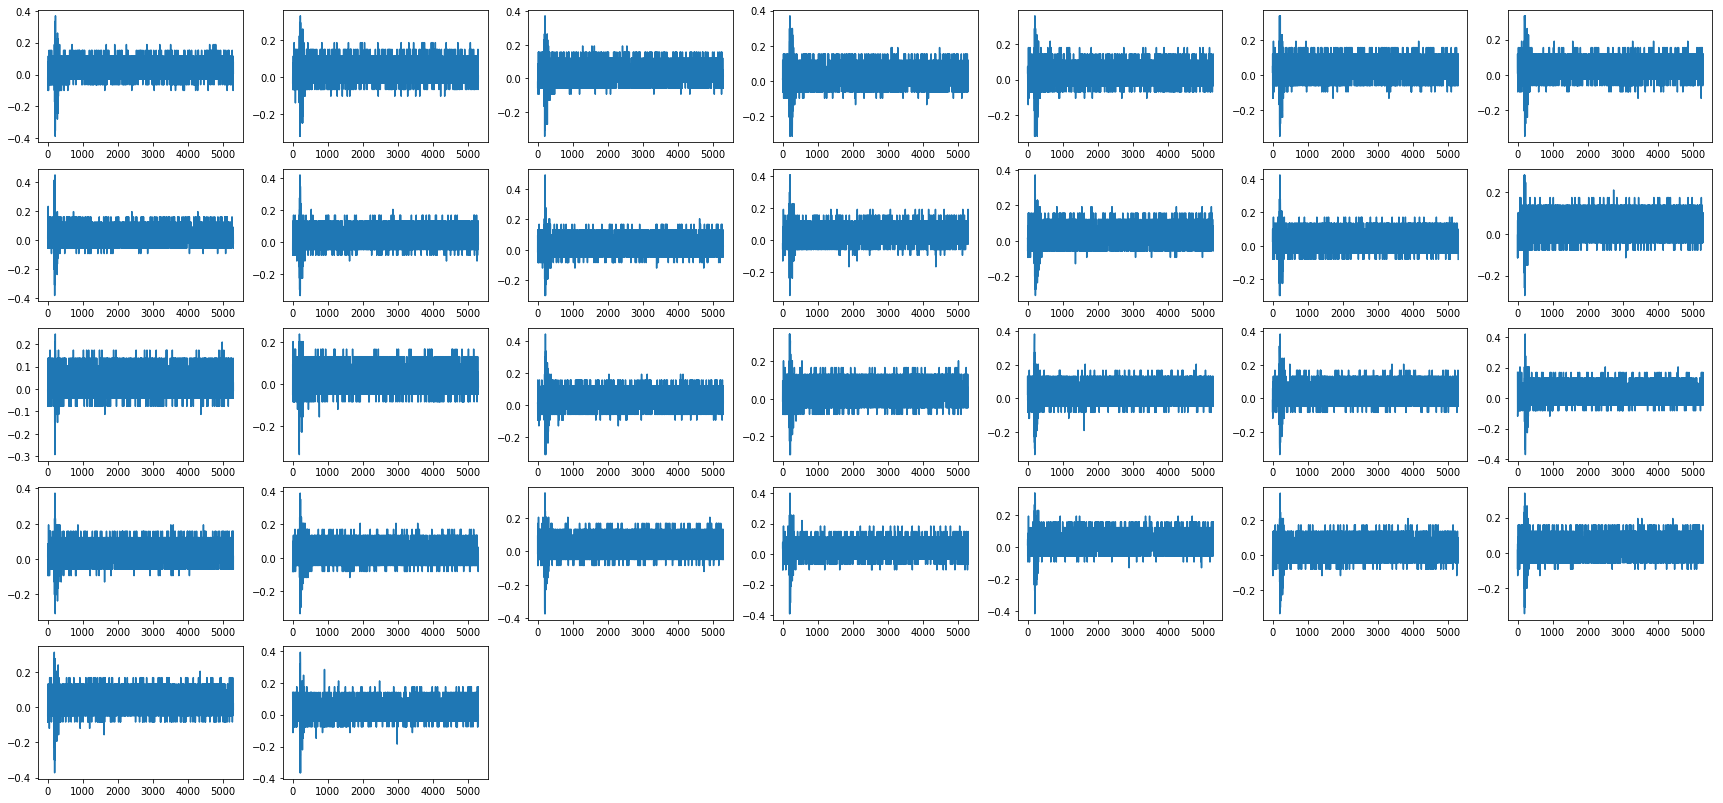

In [12]:
fft_data = fft_from_data_frame(human_data_set_offset_free)

In [204]:
np.array(fft_data)[0]
fs= 1.14e6
freq = fftfreq(fft_data[0].size, d=1/fs)


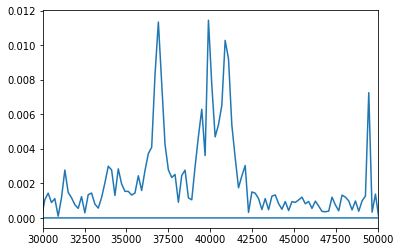

In [205]:
plt.xlim([30000,50000])
plt.plot(freq, fft_data[0])

In [94]:
human_data_set_offset_free.iloc[:,9:].abs().rolling(window=5705, min_periods=1).max()

,18,19,20,21,22,23,24,25,26,27,...,5713,5714,5715,5716,5717,5718,5719,5720,5721,5722
0,0.167084,0.131144,0.095209,0.059272,0.012604,0.084476,0.120416,0.192296,0.228226,0.264166,...,0.012604,0.048541,0.048541,0.012604,0.012604,0.023334,0.023334,0.023334,0.023334,0.023334
1,0.167084,0.131144,0.095209,0.080545,0.044610,0.084476,0.120416,0.192296,0.228226,0.264166,...,0.044610,0.048541,0.048541,0.027265,0.027265,0.027265,0.027265,0.027265,0.027265,0.027265
2,0.167084,0.138942,0.103007,0.103007,0.044610,0.084476,0.120416,0.192296,0.228226,0.292308,...,0.044610,0.048541,0.048541,0.027265,0.031132,0.031132,0.031132,0.031132,0.031132,0.031132
3,0.167084,0.138942,0.103007,0.103007,0.044610,0.108150,0.180030,0.215970,0.251900,0.292308,...,0.044610,0.048541,0.048541,0.027265,0.031132,0.035598,0.031132,0.031132,0.031132,0.031132
4,0.167084,0.138942,0.103007,0.103007,0.044610,0.108150,0.180030,0.215970,0.251900,0.292308,...,0.044610,0.048541,0.048541,0.027265,0.031132,0.035598,0.031132,0.031132,0.031132,0.031132
5,0.167084,0.138942,0.103007,0.103007,0.044610,0.108150,0.180030,0.215970,0.251900,0.292308,...,0.044610,0.048541,0.048541,0.027265,0.031132,0.035598,0.031132,0.031132,0.031132,0.031132
6,0.167084,0.138942,0.135671,0.103007,0.044610,0.108150,0.180030,0.215970,0.251900,0.292308,...,0.044610,0.048541,0.048541,0.027856,0.063791,0.035598,0.031132,0.031132,0.031132,0.031132
7,0.167084,0.138942,0.135671,0.103007,0.044610,0.108150,0.180030,0.215970,0.251900,0.292308,...,0.044610,0.048541,0.048541,0.029214,0.063791,0.035598,0.031132,0.031132,0.031132,0.031132
8,0.167084,0.147505,0.135671,0.103007,0.044610,0.108150,0.180030,0.215970,0.251900,0.292308,...,0.044610,0.048541,0.048541,0.039693,0.063791,0.035598,0.031132,0.031132,0.031132,0.031132
9,0.167084,0.147505,0.135671,0.103007,0.044610,0.108150,0.180030,0.215970,0.251900,0.292308,...,0.044610,0.048541,0.048541,0.039693,0.063791,0.035598,0.031132,0.031132,0.031132,0.031132


In [99]:
import pandas as pd

a=np.array([ 6,4,8,7,1,4,3,5,7,8,4,6,2,1,3,5,6,3,4,7,1,9,4,3,2 ])
window=5
for i in range(0,len(a)-window,1): 
    b[i] = np.amax(a[i:i+window])

NameError: name 'b' is not defined

In [137]:
from scipy.ndimage.filters import maximum_filter1d

def max_filter1d_valid(a, W):
    hW = (W-1)//2 # Half window size
    return maximum_filter1d(a,size=W)[hW:-hW]

In [215]:
w = 70000 / (1140000.0/2) # Normalize the frequency
b, a = signal.butter(5, w, 'low')
y = signal.filtfilt(b, a, human_data_set_offset_free_values[3])
w = 30000 / (1140000.0/2)
b, a = signal.butter(5, w, 'high')
y_ = signal.filtfilt(b, a, y)


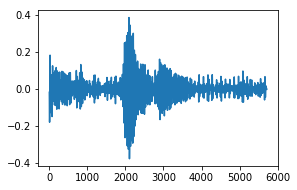

In [726]:
human_data = pd.read_csv('../../data/result/human_A_echo.csv', skiprows=[0], header= None)
human_data.shape

(1811, 1028)

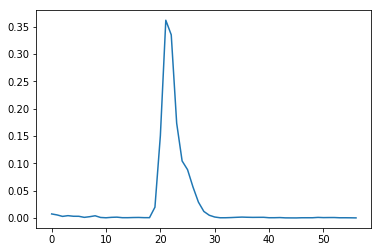

In [338]:
plt.plot(window_max_result[5])

In [108]:
THRESHOLD = 0.01
echo_set = []
WINDOW_SIZE = 100
dfObjs = pd.DataFrame(new_data) 
variance_list = dfObj.rolling(window=WINDOW_SIZE, axis=1)


In [96]:
from scipy.signal import find_peaks


In [98]:
dfObjs.values[0][99:]

array([-0.06678227, -0.07246651, -0.0746896 , ...,  0.00435241,
        0.00113782, -0.00157089])

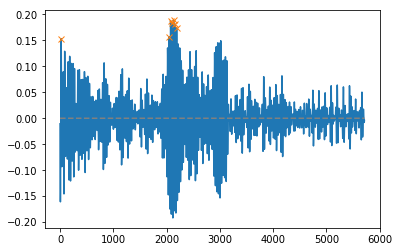

array([  20, 2048, 2075, 2103, 2132, 2161, 2189])

In [91]:
WINDOW = 1000
DATA_SIZE = 5714
SIGNAL_SIZE = 1024
THRESHOLD = 0.15
LEFT_ECHO_SIZE = 256
length_of_window = round(DATA_SIZE/WINDOW)


def get_echo_set_location(data): 
    window_peak_locations = []
    for i in range(0, length_of_window):
        window_peak = d[i*WINDOW:(i+1)*WINDOW].max()
        if window_peak >= THRESHOLD:
            window_peak_location = i*WINDOW + d[i*WINDOW:(i+1)*WINDOW].argmax()
            if i>0 or window_peak_location > LEFT_ECHO_SIZE:
                window_peak_locations.append(window_peak_location)
    echo_set = []
    if len(window_peak_locations):
        echo_set = [window_peak_locations[0]]
        prev_echo = window_peak_locations[0]
        for w in window_peak_locations:
            if prev_echo - w > SIGNAL_SIZE:
                echo_set.append(w)
            prev_echo = w
    return echo_set

In [258]:
def get_echo_peaks(peaks, window_size=1024, echo_left_size=256):
    prev_value = peaks[0]
    echos = []
    for i in peaks:
        if len(echos):
            if i - prev_value > 1024:
                echos.append(i)
        if not len(echos) and i > echo_left_size:
            echos = [i]
        prev_value = i
    return echos
result_values = result.values
a = result.rolling(window=100, axis=1).var()
echo_set=[]
for i, d in enumerate(a.values):
    peaks, _ = signal.find_peaks(d, height=0.02)
    if len(peaks):
        echo_peaks = get_echo_peaks(
            peaks, 1024, 256)
        if len(echo_peaks):
            for index, e in enumerate(echo_peaks):
                echo_left_size = e - 256
                value = result_values[i]
                echo_data = {
                    'ECHO': value[slice(echo_left_size, echo_left_size+1024)],
                    'ECHO_COUNTER': index + 1
                }
                echo_set.append(echo_data)

In [314]:
df = pd.DataFrame(echo_set)

In [315]:
a = pd.concat([df.ECHO_COUNTER, pd.DataFrame(df.ECHO.tolist())], axis=1)

In [309]:
'aa'.upper()

'AA'

In [302]:
type(a) == None

False

In [316]:
a = [{'id':1},{'id':2}]

In [3]:
human_data = pd.read_csv('../../data/result/blue_jeans.csv')

In [15]:
human_data.iloc[:,5:]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.050935,0.079740,0.104282,0.123319,0.135946,0.141640,0.140281,0.132144,0.117863,0.098377,...,0.150238,0.209866,0.260693,0.300041,0.325703,0.336058,0.330171,0.307865,0.269758,0.217261
1,0.047871,0.076472,0.101861,0.122734,0.137996,0.146823,0.148714,0.143528,0.131494,0.113201,...,0.151236,0.208044,0.255887,0.292110,0.314572,0.321771,0.312939,0.288110,0.248132,0.194648
2,0.056377,0.086340,0.112006,0.131945,0.145026,0.150505,0.148077,0.137903,0.120612,0.097258,...,0.180529,0.240091,0.289619,0.326361,0.348092,0.353240,0.341001,0.311405,0.265360,0.204642
3,0.052070,0.076595,0.097227,0.112986,0.123154,0.127300,0.125293,0.117299,0.103768,0.085409,...,0.200823,0.260340,0.308327,0.341976,0.359128,0.358422,0.339396,0.302553,0.249366,0.182218
4,0.023725,0.053798,0.080754,0.103316,0.120453,0.131433,0.135844,0.133614,0.125008,0.110607,...,0.193811,0.252603,0.300498,0.334898,0.353791,0.355865,0.340592,0.308292,0.260132,0.198106
5,0.053109,0.079641,0.102411,0.120464,0.133075,0.139774,0.140362,0.134911,0.123756,0.107472,...,0.161369,0.220676,0.271091,0.309785,0.334375,0.343075,0.334827,0.309403,0.267467,0.210595
6,-0.062437,-0.083470,-0.100083,-0.111612,-0.117673,-0.118175,-0.113313,-0.103545,-0.089555,-0.072203,...,-0.196802,-0.263894,-0.319010,-0.359042,-0.381635,-0.385318,-0.369605,-0.335023,-0.283094,-0.216253
7,0.005845,-0.026049,-0.055779,-0.081966,-0.103481,-0.119498,-0.129518,-0.133379,-0.131239,-0.123544,...,0.170816,0.238633,0.294485,0.335169,0.358294,0.362421,0.347156,0.313176,0.262198,0.196884
8,0.053861,0.023664,-0.007174,-0.037137,-0.064776,-0.088789,-0.108086,-0.121842,-0.129538,-0.130988,...,-0.208238,-0.261018,-0.301697,-0.328032,-0.338490,-0.332340,-0.309706,-0.271560,-0.219677,-0.156540
9,-0.007947,-0.030432,-0.051349,-0.069566,-0.084096,-0.094160,-0.099241,-0.099108,-0.093835,-0.083786,...,-0.181643,-0.229770,-0.266814,-0.290751,-0.300209,-0.294552,-0.273927,-0.239266,-0.192251,-0.135236


FileNotFoundError: [Errno 2] File b'../../data/1mhz_data/human/human_A/80/1.csv' does not exist: b'../../data/1mhz_data/human/human_A/80/1.csv'

In [96]:
56000/(114000*0.5)

0.9824561403508771